In [1]:
"""
DATA PROCESSING PIPELINE FOR GROMACS XVG FILES
Created: 2025-06-11
Author: Qin Zhang

DESCRIPTION:
This cell contains core functions for parsing and validating GROMACS .xvg output files.
Key features:
- Skips metadata lines (starting with #, @, &)
- Extracts time-value pairs (first two columns)
- Ensures numeric data integrity

DEPENDENCIES:
- Python 3.8+
- pandas >= 1.4
- numpy >= 1.22

FILE CONVENTIONS:
- Input: .xvg files from 'gmx hbond'
- Output: DataFrame with ['time', 'value'] columns
"""
#%% Cell 1 - Improved Data Reading Function
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn as sns
from scipy.stats import sem
import matplotlib.style

def read_data_to_df(filename: str) -> pd.DataFrame:
    """Parse GROMACS XVG file into structured DataFrame
    
    Args:
        filename: Path to .xvg file
        
    Returns:
        pd.DataFrame: Time-series data with columns ['time', 'value']
        
    Notes:
        - Skips all metadata lines (starting with #, @, &)
        - Only processes numeric data rows
        - Takes first two columns as time-value pair
    """
    data = []
    
    with open(filename, 'r') as f:
        for line in f:
            # Skip comment lines and metadata
            if line.startswith(('#', '@', '&', 'title', 'xaxis', 'yaxis')):
                continue
            # Split line into columns and convert to float
            try:
                cols = list(map(float, line.split()))
                if len(cols) >= 2:  # Accept lines with 2 or more columns
                    data.append(cols[:2])  # Take first two columns
            except (ValueError, IndexError):
                continue     
    # Create DataFrame from valid data         
    return pd.DataFrame(data, columns=['time', 'value'])


def validate_data(df: pd.DataFrame) -> pd.DataFrame:
    """Ensure DataFrame contains only numeric values
    
    Args:
        df: Input DataFrame from read_data_to_df()
        
    Returns:
        Validated DataFrame
        
    Raises:
        ValueError: If non-numeric data detected
    """
    if not np.issubdtype(df['value'].dtype, np.number):
        raise ValueError("Non-numeric data detected in 'value' column.")
    return df

In [2]:
#%% Cell 2 - Optimized Data Processing
"""
DATA AGGREGATION AND STATISTICAL PROCESSING

DESCRIPTION:
Configuration and processing pipeline for multi-condition RNA simulation data.
Key components:
1. CONDITION dictionary: Defines experimental parameters
   - base_path: Root directory for simulation data
   - normalization: Scaling factor per nucleotide
   - files: Replica file paths
   - concentrations: Salt condition mapping
   
2. process_data(): Core analysis workflow
   - Reads replica files
   - Normalizes values (per nucleotide)
   - Calculates global mean, SD, SEM
   - Prints quality control metrics

STATISTICAL METHODS:
- Normalization: value / (nucleotide_count * residue_count)
- Global mean: Average of replica means
- Standard deviation: With Bessel correction (n-1)
- Standard error: SEM = SD / sqrt(n_replicas)

NOTE: All paths correspond to Zenodo dataset structure
"""
# Data configuration
CONDITIONS = {
    '3xG4C2': {
        'base_path': '/media/qzhang04/3xG4C2/zenodo/',
        'normalization': 12 * 18,
        'files': ['C1/hb_BBvsMG6.xvg', 'C2/hb_BBvsMG6.xvg', 'C3/hb_BBvsMG6.xvg', 'C4/hb_BBvsMG6.xvg'],
        'concentrations': {
             '17Na_10Mg':   ('A_3xG4C2_800uM_12_17mMNaCl_10mMMgCl2/lake_10us/',  17),
             '35Na_21Mg':   ('A_3xG4C2_800uM_12_35mMNaCl_21mMMgCl2/lake_10us/',  35),
             '70Na_42Mg':   ('A_3xG4C2_800uM_12_70mMNaCl_42mMMgCl2/lake_10us/',  70),
             '139Na_83Mg':  ('A_3xG4C2_800uM_12_139mMNaCl_83mMMgCl2/lake_10us/', 139),
             '278Na_167Mg': ('A_3xG4C2_800uM_12_278mMNaCl_167mMMgCl2/lake_10us/',278),
             '487Na_292Mg': ('A_3xG4C2_800uM_12_487mMNaCl_292mMMgCl2/lake_10us/',487),
             '696Na_417Mg': ('A_3xG4C2_800uM_12_696mMNaCl_417mMMgCl2/lake_10us/',696),
        },
    },
   '5xG4C2': {
       'base_path': '/media/qzhang04/3xG4C2/zenodo/',
       'normalization': 12 * 30,
       'files': ['C1/hb_BBvsMG6.xvg', 'C2/hb_BBvsMG6.xvg', 'C3/hb_BBvsMG6.xvg', 'C4/hb_BBvsMG6.xvg'],
       'concentrations': {
            '17Na_10Mg':   ('B_5xG4C2_800uM_12_17mMNaCl_10mMMgCl2/lake_10us/',  17),
            '35Na_21Mg':   ('B_5xG4C2_800uM_12_35mMNaCl_21mMMgCl2/lake_10us/',  35),
            '70Na_42Mg':   ('B_5xG4C2_800uM_12_70mMNaCl_42mMMgCl2/lake_10us/',  70),
            '139Na_83Mg':  ('B_5xG4C2_800uM_12_139mMNaCl_83mMMgCl2/lake_10us/', 139),
            '278Na_167Mg': ('B_5xG4C2_800uM_12_278mMNaCl_167mMMgCl2/lake_10us/',278),
            '487Na_292Mg': ('B_5xG4C2_800uM_12_487mMNaCl_292mMMgCl2/lake_10us/',487),
            '696Na_417Mg': ('B_5xG4C2_800uM_12_696mMNaCl_417mMMgCl2/lake_10us/',696),               
        }
    }
}

def process_data(config):
    """Process simulation data across concentrations and replicas
    
    Args:
        config: Condition configuration dictionary
        
    Returns:
        dict: Processed results per concentration with:
            - mean: Global average
            - std: Standard deviation
            - sem: Standard error of mean
            
    Workflow:
        1. For each concentration:
            a. Load replica files
            b. Validate data
            c. Normalize values
            d. Calculate replica means
        2. Compute global statistics
    """
    results = {}
    for label, (path_suffix, conc) in config['concentrations'].items():
        full_path = config['base_path'] + path_suffix
        dfs = [validate_data(read_data_to_df(full_path + f)) for f in config['files']]
        replica_means = []
        for df in dfs:
            normalized = df['value'].iloc[-10000:] / config['normalization']
            replica_means.append(normalized.mean())
        global_mean = np.mean(replica_means)# average of 4 replicas
        deviations = [x - global_mean for x in replica_means]
        sd = np.sqrt(sum(d**2 for d in deviations) / (len(replica_means)-1))
        print(f"\n=== Current concentration: {conc} mM ===")
        print(f"Replica mean: {[round(x, 4) for x in replica_means]}")
        print(f"Global mean (Global Mean): {global_mean:.4f}")
        print(f"Standard deviation (SD): {sd:.4f}")
        print(f"Standard error (SEM): {sem(replica_means):.4f}")
        results[conc] = {
            'mean': global_mean,
            'std': sd,  
            'sem': sem(replica_means)
        }
    return results
# Process all conditions
data = {k: process_data(v) for k, v in CONDITIONS.items()}



=== Current concentration: 17 mM ===
Replica mean: [0.9478, 0.9244, 0.9827, 0.9083]
Global mean (Global Mean): 0.9408
Standard deviation (SD): 0.0323
Standard error (SEM): 0.0161

=== Current concentration: 35 mM ===
Replica mean: [1.4163, 1.5133, 1.481, 1.4256]
Global mean (Global Mean): 1.4590
Standard deviation (SD): 0.0461
Standard error (SEM): 0.0230

=== Current concentration: 70 mM ===
Replica mean: [1.5968, 1.5664, 1.522, 1.5967]
Global mean (Global Mean): 1.5705
Standard deviation (SD): 0.0353
Standard error (SEM): 0.0177

=== Current concentration: 139 mM ===
Replica mean: [1.6219, 1.6059, 1.6189, 1.6365]
Global mean (Global Mean): 1.6208
Standard deviation (SD): 0.0126
Standard error (SEM): 0.0063

=== Current concentration: 278 mM ===
Replica mean: [1.738, 1.7468, 1.7388, 1.7423]
Global mean (Global Mean): 1.7415
Standard deviation (SD): 0.0040
Standard error (SEM): 0.0020

=== Current concentration: 487 mM ===
Replica mean: [1.6811, 1.7066, 1.6942, 1.6778]
Global mean (Gl


=== Condition: 3xG4C2 ===
Salt:  17 mM | Global Mean: 0.9408 | SD: 0.0323 | 
Salt:  35 mM | Global Mean: 1.4590 | SD: 0.0461 | 
Salt:  70 mM | Global Mean: 1.5705 | SD: 0.0353 | 
Salt: 139 mM | Global Mean: 1.6208 | SD: 0.0126 | 
Salt: 278 mM | Global Mean: 1.7415 | SD: 0.0040 | 
Salt: 487 mM | Global Mean: 1.6899 | SD: 0.0132 | 
Salt: 696 mM | Global Mean: 1.5417 | SD: 0.0438 | 

=== Condition: 5xG4C2 ===
Salt:  17 mM | Global Mean: 0.5400 | SD: 0.0198 | 
Salt:  35 mM | Global Mean: 1.0335 | SD: 0.0207 | 
Salt:  70 mM | Global Mean: 1.4694 | SD: 0.0223 | 
Salt: 139 mM | Global Mean: 1.6442 | SD: 0.0373 | 
Salt: 278 mM | Global Mean: 1.6794 | SD: 0.0068 | 
Salt: 487 mM | Global Mean: 1.6321 | SD: 0.0269 | 
Salt: 696 mM | Global Mean: 1.6611 | SD: 0.0177 | 


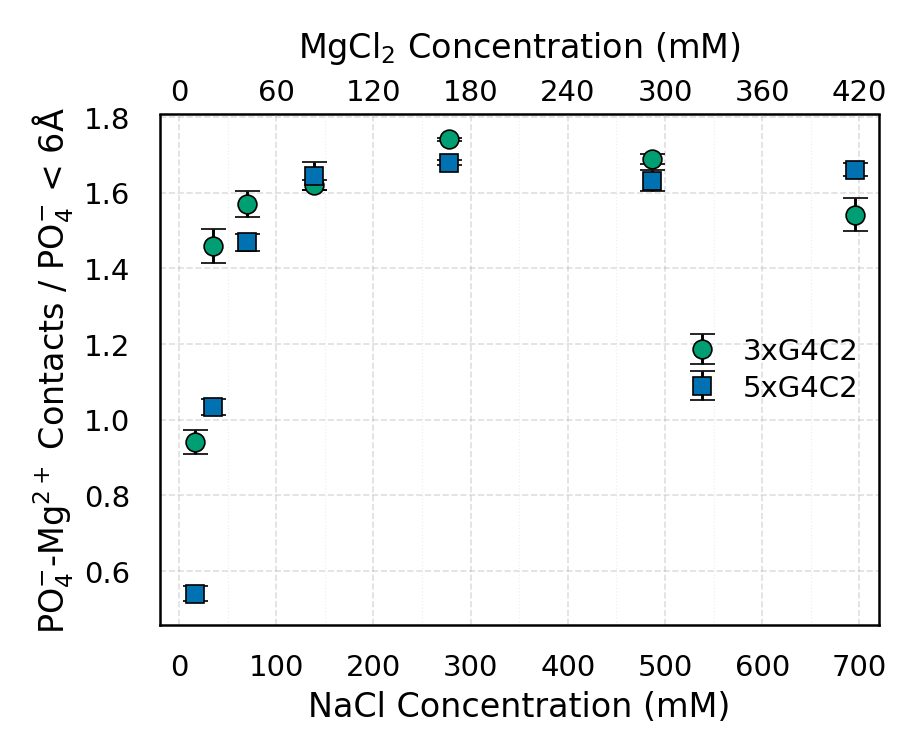

In [3]:
#%% Cell 3 
"""
PUBLICATION-QUALITY FIGURE GENERATION

DESCRIPTION:
Creates multi-panel figure for submission with:
- Dual x-axis (NaCl and MgCl₂ concentrations)
- Custom error bars (SD from replicas)
- Journal-compliant formatting

KEY PARAMETERS:
- Font size: 7pt (main text), 8pt (labels)
- Figure size: 3.33 in (single-column width)
- Color scheme: Colorblind-friendly palette
- Error bars: Black caps with 0.7pt width

OUTPUT:
- .png (300 DPI, tight bounding box)

JOURNAL REQUIREMENTS:
- Mathtext regular style
- 300 DPI resolution
"""
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
def create_figure(data_dict):

    plt.rcParams.update({
        'font.size': 7,  # Base font size
        'axes.labelsize': 8,  # Axis label size
        'xtick.labelsize': 7,  # Tick label size
        'ytick.labelsize': 7,
        'legend.fontsize': 7,
        'figure.figsize': (3.33, 2.5),  # Single-column width
        'axes.linewidth': 0.6,  # Axis spine width
        'lines.linewidth': 1.0,  # Data line width
        'lines.markeredgewidth': 0.6,  # Marker edge width
        'grid.linewidth': 0.4,  # Grid line width
        'xtick.major.width': 0,  # Hide x-axis ticks
        'xtick.minor.width': 0,
        'ytick.major.width': 0,
        'figure.dpi' : 300,  # Screen resolution
        'savefig.dpi': 300,  # Output resolution
        'savefig.format': 'png',
        'pdf.fonttype': 42,  # Embeddable Type 42 fonts
        'font.family': 'DejaVu Sans',  #  recommended
        'mathtext.default': 'regular'  # Math font style
    })
    fig, ax = plt.subplots()
    colors = {
        '3xG4C2': '#009E73',  # green
        '5xG4C2': '#0072B2',  # bule
        '8xG4C2': '#E69F00'   # orange
    }
    nacl_to_mgcl2 = lambda x: x * 0.6
    mgcl2_to_nacl = lambda x: x / 0.6
    markers = {
        '3xG4C2': 'o',  # Circle
        '5xG4C2': 's',  # Square
        '8xG4C2': 'D'   # Diamond
    }

    for idx, (condition, values) in enumerate(data_dict.items()):
        concs = sorted(values.keys())
        means = [values[c]['mean'] for c in concs]
        errors = [values[c]['std'] for c in concs]# Using SD for error bars
        print(f"\n=== Condition: {condition} ===")
        for c in concs:
            print(f"Salt: {c:3d} mM | "
                  f"Global Mean: {values[c]['mean']:.4f} | "
                  f"SD: {values[c]['std']:.4f} | ")

        ax.errorbar(
            concs, means, yerr=errors,
            fmt=markers[condition],
            markersize=4.5,
            capsize=3,
            capthick=0.7,
            ecolor='black',               # Error bar color
            elinewidth=0.7,
            color=colors[condition],      # Marker fill color
            markerfacecolor=colors[condition],  
            markeredgecolor='k',          # Marker edge color
            markeredgewidth=0.4,
            label=condition,
            zorder=3  # Ensure markers on top
        )

    nacl_to_mgcl2 = lambda x: x * 0.6
    ax2 = ax.secondary_xaxis('top', functions=(nacl_to_mgcl2, mgcl2_to_nacl))

    ax.spines['top'].set_color('none')
    ax.set_xlabel('NaCl Concentration (mM)', labelpad=2)
    ax.set_ylabel('PO$_4^{-}$-Mg$^{2+}$ Contacts / PO$_4^{-}$ < 6Å', labelpad=2)
    ax2.set_xlabel('MgCl$_2$ Concentration (mM)', labelpad=5)
    ax.set_xlim(-20, 720)
    ax.xaxis.set_major_locator(MultipleLocator(100))
    ax.xaxis.set_minor_locator(MultipleLocator(50))
    ax2.xaxis.set_major_locator(MultipleLocator(60))
    ax2.tick_params(axis='x', which='both', length=0,  labelcolor='black',  pad=2)
    ax.grid(True, which='major', linestyle='--', linewidth=0.4, alpha=0.4)
    ax.grid(True, which='minor', linestyle=':', linewidth=0.3, alpha=0.2)
    leg = ax.legend(
        frameon=False,
        loc='center right',
        # bbox_to_anchor=(1.02, 0.98),  
        borderpad=0.2,
        handletextpad=0.4,
        labelspacing=0.3
    )
    # Layout adjustments
    plt.subplots_adjust(
        left=0.18,   # Left margin
        bottom=0.16, # Bottom margin
        top=0.84     # Top margin
    )
    # Quality control check
    def verify_publication_ready(fig):
        """Validate figure"""
        DPI = 300
        fig_width_inch = 3.33
        min_font_pt = 4.5
        assert 7 * (3.33/3.54) >= 4.5  # Font size check
    
    verify_publication_ready(fig)
    
    # Save figure with publication settings
    plt.savefig(
        'FigureS2d.png',
        dpi=300,
        bbox_inches='tight',  # Minimize white space
        pad_inches=0.02,      # Minimal padding
    )
create_figure(data)
